In [39]:
%%html
<style>
body {
    font-family: "Consolas", monospace;
}
</style> 

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# UCI Real State Valuation

En el siguiente notebook se utiliza el "Real state valuation data set". Este contiene información histórica de valuaciones inmobiliarias realizadas en Sindian District, New Taipei City, Taiwan en los años 2012 y 2013. 

# Descripción de las variables

- **transaction_date**: fecha de la transacción (por ejemplo, 2013.250=2013 March, 2013.500=2013 June, etc.)
- **house_age**: antigüedad de la casa (años)
- **distance_to_nearest_MRT_station**: distancia a la estación MRT más cercana (metros)
- **number_of_convenience_stores**: número de tiendas de conveniencia cercanas (unidades)
- **latitude**: coordenada geográfica correspondiente a la latitud (grados)
- **longitude**: coordenada geográfica correspondiente a la longitud (grados)
- **price_of_unit_area**: precio de la casa por unidad de area (10000 dólares taiwaneses/Ping, 1 Ping: 3.3 metros cuadrados)

El objetivo es predecir el precio por unidad de área e identificar cómo las diferentes variables influyen en el precio.

Extraído de https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

In [3]:
# importar las librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
def plot_surface(X, y, model, diff=0.01, N=100, show_train_data=True):
    """
    X: matriz de datos de dos columnas
    y: vector numérico
    model: modelo que tome como inputs las dos columnas de X (X0 y X1)
    
    Esta función grafica la función de R^2 a R estimada por model. Se grafica solo los puntos
    que sean cercanos a las observaciones contenidas en X. Adicionalmente, también se grafica la
    distribución conjunta de X0 y X1.
    
    """
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-diff, X[:, 0].max()+diff
    min2, max2 = X[:, 1].min()-diff, X[:, 1].max()+diff
    # define the x and y scale
    x1grid = np.linspace(min1, max1, N)
    x2grid = np.linspace(min2, max2, N)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    y_hat = model.predict(grid)

    r1, r2, y_hat = r1.flatten(), r2.flatten(), y_hat.flatten()
    r1_f, r2_f, y_hat_f = [], [], []
    
    for a, b, c in zip(r1, r2, y_hat):
        if ((a - X[:, 0])**2 + (b - X[:, 1])**2 ).min()**0.5 <= 0.01:
            r1_f.append(a)
            r2_f.append(b)
            y_hat_f.append(c)
        
    r1_f, r2_f, y_hat_f = np.array(r1_f), np.array(r2_f), np.array(y_hat_f) 
    
    
    from matplotlib.colors import TwoSlopeNorm
    fig, axis = plt.subplots(1, 1, figsize=(12, 7))
    
    axis = plt.scatter(x=r1_f, 
                       y=r2_f, 
                       c = y_hat_f,
                       cmap= plt.get_cmap("coolwarm"),
                       marker=".",
                       norm=TwoSlopeNorm(0, vmin=-15, vmax=15)
                       )
    plt.colorbar()
    
    if show_train_data:
        axis = plt.scatter(X[:, 0],X[:, 1], marker=".", color="black")
    
    plt.xlabel('longitude')
    plt.ylabel('latitude')

In [5]:
def RMSE(x, y): 
    """
    Función root-mean squared error
    """
    return ((x-y)**2).mean()**0.5

In [6]:
def obvs_vs_pred_plot(Y_OBVS, Y_PRED, TITLE):
    """
    Esta función grafica la distribución de los errores
    """
    
    fig, axis = plt.subplots(1, 2, figsize=(9, 4))
    
    sns.histplot(Y_OBVS - Y_PRED, ax=axis[0])
    axis[0].set_title(f"{TITLE} histograma de los errores")
    axis[0].set_xlabel("Error")
    axis[0].set_ylabel("Frecuencia")
    
    sns.scatterplot(x=Y_OBVS, y=Y_PRED)
    sns.lineplot(x=[Y_OBVS.min(), Y_OBVS.max()],
                 y=[Y_OBVS.min(), Y_OBVS.max()],
                 color="red",
                 ax=axis[1]
                )
    
    axis[1].set_title(f"{TITLE} Obvs vs Pred")
    axis[1].set_xlabel("Observado")
    axis[1].set_ylabel("Predicho")
    plt.show()

# Lectura de los datos

En el dataset, existe una observación cuyo precio por unidad de área es 120. Ya que este valor es un outlier, se procede a eliminarlo. Adicionalmente, se observa que no existen valores nulos.

A continuación se muestra la distribución de cada una de las variables. Se puede comprobar que no existen fuertes outliers en los datos.

In [7]:
path = r"datasets\UCI real state valuation\Real estate valuation data set.csv"
data = pd.read_csv(path, index_col=0)

outlier_filter = data["price_of_unit_area"] <= 100
data = data.loc[outlier_filter, :]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413 entries, 1 to 414
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   transaction_date                 413 non-null    float64
 1   house_age                        413 non-null    float64
 2   distance_to_nearest_MRT_station  413 non-null    float64
 3   number_of_convenience_stores     413 non-null    int64  
 4   latitude                         413 non-null    float64
 5   longitude                        413 non-null    float64
 6   price_of_unit_area               413 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.8 KB


In [8]:
data.sample(10)

,transaction_date,house_age,distance_to_nearest_MRT_station,number_of_convenience_stores,latitude,longitude,price_of_unit_area
No,,,,,,,
270,2013.000,17.6,837.72330,0,24.96334,121.54767,23.0
147,2012.750,0.0,185.42960,0,24.97110,121.53170,52.2
222,2013.333,9.0,1402.01600,0,24.98569,121.52760,38.5
77,2013.583,35.9,616.40040,3,24.97723,121.53767,36.8
413,2013.000,8.1,104.81010,5,24.96674,121.54067,52.5
223,2013.583,30.6,431.11140,10,24.98123,121.53743,48.5
179,2013.500,13.1,1144.43600,4,24.99176,121.53456,36.7
161,2012.917,3.5,49.66105,8,24.95836,121.53756,57.8
176,2013.083,30.2,472.17450,3,24.97005,121.53758,36.5


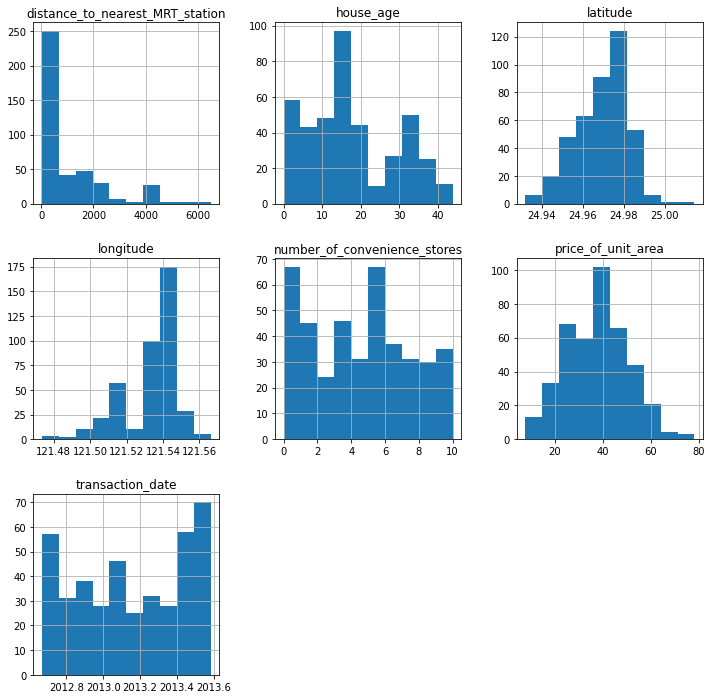

In [9]:
data.hist(figsize=(12, 12));

# Separación del conjunto de datos en train y test

Se procede a separar el dataset en dos conjuntos
- train: este conjunto se utilizará para el entrenamiento los modelos y  la optimización de hiperparámetros
- test: este conjunto se utilizará para evaluar el rendimiento de los modelos terminados

Para asegurar que los resultados sean significativos, se aplica muestreo estratificado para separar el dataset. Los estratos están determinados por la variable "price_of_unit_area", la cual se discretiza en los intervalos (-Inf, 30), (30, 50) y (50, +Inf)

El número de observaciones que corresponde a cada dataset es el siguiente:
- train: 289 obvs
- test: 124 obvs

In [10]:
from sklearn.model_selection import train_test_split

# crear la variable estrato
data["strat"] = pd.cut(data["price_of_unit_area"], [float("-Inf"), 30, 50, float("Inf")], labels=False)

# separación de las variables de entrada y salida
features = data.drop(["price_of_unit_area"], axis=1)
target = data["price_of_unit_area"].copy()

# particionamiento estratificado de los datos
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.3, 
    stratify=features["strat"],
    random_state=0)

# eliminar la variable strat
X_train = X_train.drop(["strat"], axis=1)
X_test = X_test.drop(["strat"], axis=1)

# Exploración de los datos de entrenamiento

En esta etapa se realiza un analisis exploratorio de los datos para tratar de determinar las relaciones que existen enntre las distintas variables de entrada y el precio.

En el siguiente gráfico se muestra la variación de los precios de unidad de área a través del tiempo. A primera vista, no se observa ninguna relación entre ambos.

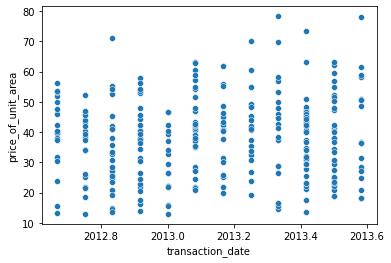

In [11]:
sns.scatterplot(x=X_train["transaction_date"], y=y_train);

A continuación, se muestra la distribución conjunta de las siguientes variables
- antiguedad de la casa
- distancia a la estación MRT más cercana
- número de tiendas de conveniencia cercanas

Notas
- con excepción del número de tiendas de conveniencia y la distancia a la estación MRT más cercana, las variables parecen ser independientes.

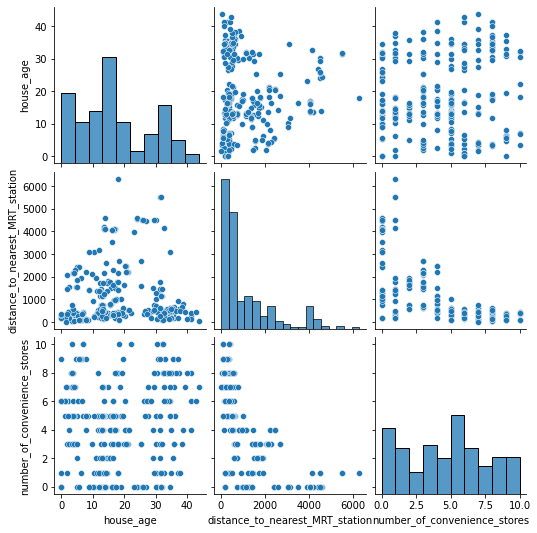

In [12]:
cols = ['house_age', 
        'distance_to_nearest_MRT_station',
        'number_of_convenience_stores']

sns.pairplot(X_train.loc[:, cols]);

A continuación se analiza la relación de las variables previamente analizadas con el precio por unidad de área.

A primera vista, el precio por unidad de area varía de forma inversa a la distancia a la estación MRT más cercana. Para observar la relación de forma más clara se calcula el logaritmo de esta.

Ahora se puede observa mejor los efectos de las variables en el precio

Notas:
- la relación entre el precio y la antigüedad parece ser cuadrática
- el precio varía de forma lineal con respecto al log_MRT_dist y el número de tiendas de conveniencia

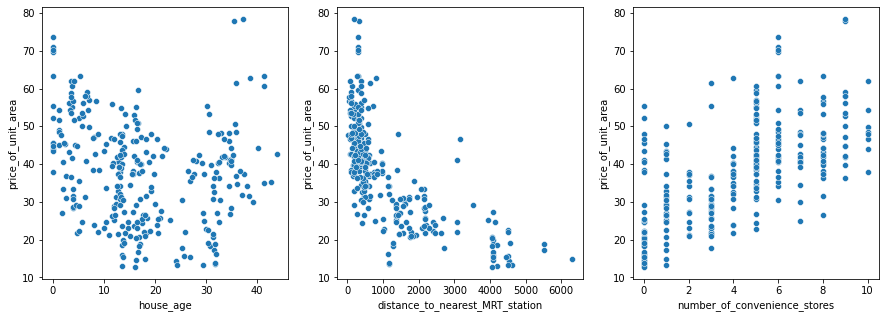

In [40]:
cols = ['house_age', 
        'distance_to_nearest_MRT_station',
        'number_of_convenience_stores']

p = len(cols)

fig, axis = plt.subplots(1, p, figsize=(p*5, 5))

for i in range(p):
    sns.scatterplot(x=X_train[cols[i]], y=y_train, ax=axis[i])

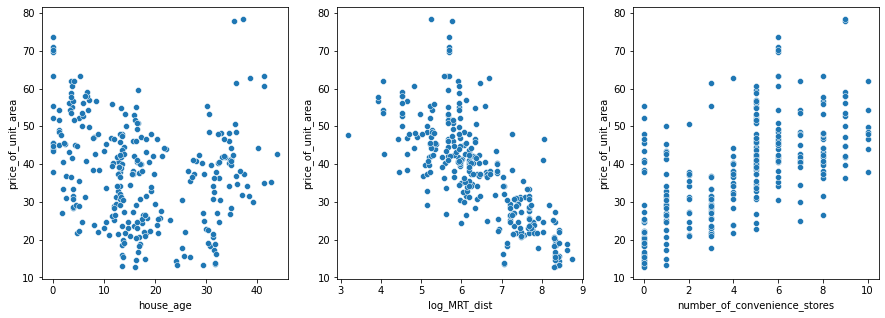

In [41]:
X_train["log_MRT_dist"] = np.log(X_train["distance_to_nearest_MRT_station"]+1)

cols = ['house_age', 'log_MRT_dist', 'number_of_convenience_stores']

p = len(cols)
fig, axis = plt.subplots(1, p, figsize=(5*p, 5))

for i in range(p):
    sns.scatterplot(x=X_train[cols[i]], y=y_train, ax=axis[i])

Posteriormente, se analiza el efecto de la localización geográfica en el precio.

Aunque a primera vista las residencias en el noreste parecen tener precios superiores, se observa que estas propiedades tienden a estar más cerca a una estación MRT y disponen de mayor cantidad de tiendas de conveniencia en la cercanía (anteriormente se obsevó que estas variables se correlacionan con el precio).  De esta manera, para determinar el efecto de la localización geográfica en el precio primero se debe eliminar el efecto de estas.

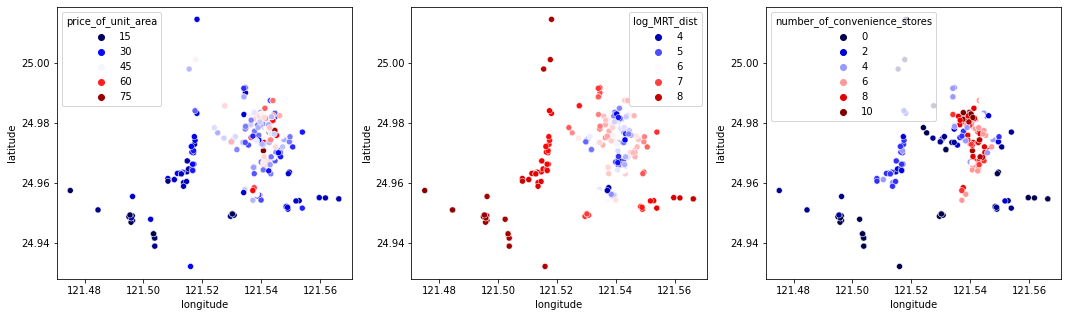

In [15]:
fig, axis = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x="longitude", y="latitude", 
                hue=y_train, 
                data=X_train, 
                palette=plt.get_cmap("seismic"),
                ax=axis[0]);

sns.scatterplot(x="longitude", y="latitude", 
                hue="log_MRT_dist", 
                data=X_train, 
                palette=plt.get_cmap("seismic"),
                ax=axis[1]);

sns.scatterplot(x="longitude", y="latitude", 
                hue="number_of_convenience_stores", 
                data=X_train, 
                palette=plt.get_cmap("seismic"),
                ax=axis[2]);

# Modelamiento

A continuación se procede a modelar el precio por unidad de área. Para evaluar los modelos, se utilizará el RMSE (root mean squared error).


Antes de realizar la estimación se calcula el índice VIF, para detectar multicolinealidad entre las variables de entrada. Valores menores a 5 indican que no se presenta multicolinealidad.

Como se puede observar en la celda "resultado 1", la inclusión de los variables latitud y longitud generan problemas de multicolinealidad, de forma similar, el término cuadrático de house_age. Así, se procede a incluir solo las siguientes variables:

- house_age
- log_MRT_dist
- number_of_convenience_stores

En la celda "resultado 2" se muestra los resultados del modelo de regresión lineal. Se observa que el modelo es altamente significativo (F-statistic=148.8). Adicionalmente, todas las variables incluídas son altamente significativas.

Para estimar el error de generalización del modelo se utilizó 5-fold cross-validation (celda "resultado 3"). Se observa que la media del error es 8.363 y la desviación estándar es 1.286.

Finalmente, en la celda "resultado 4", se muestra la distribución de los errores.

In [16]:
import statsmodels.api as sm
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [17]:
# verificar multicolinealidad de las variables de entrada
def calculate_vif(X):  
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    n_var = X.shape[1]
    vif = pd.DataFrame()
    
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(n_var)]
    vif["Features"] = X.columns
    return vif

###  resultado 1

In [18]:
# calcular los términos cuadráticos de la antiguedad de las casas
X_train["house_age_sq"] = X_train["house_age"]**2 

print()
print("coeficientes VIF")
print(calculate_vif(X_train.loc[:, ['house_age', 'log_MRT_dist','number_of_convenience_stores']]))

print()
print("coeficientes VIF")
print(calculate_vif(X_train.loc[:, ['house_age', 'house_age_sq', 'log_MRT_dist','number_of_convenience_stores']]))


print()
print("coeficientes VIF")
print(calculate_vif(X_train.drop(["transaction_date", "house_age_sq", "distance_to_nearest_MRT_station"], axis=1)).round(3))


coeficientes VIF
   VIF Factor                      Features
0    3.485156                     house_age
1    3.805457                  log_MRT_dist
2    2.380970  number_of_convenience_stores

coeficientes VIF
   VIF Factor                      Features
0   52.522078                     house_age
1   29.188239                  house_age_sq
2    8.781047                  log_MRT_dist
3    2.381646  number_of_convenience_stores

coeficientes VIF
    VIF Factor                      Features
0        3.504                     house_age
1        7.087  number_of_convenience_stores
2  5100254.750                      latitude
3  5099304.072                     longitude
4       71.710                  log_MRT_dist


In [19]:
# definición del modelo de regresión lineal

model_1 = Pipeline([
    ("regressor", LinearRegression(fit_intercept=True))
])

stg1_filter = [
    'house_age', 
    'log_MRT_dist',
    'number_of_convenience_stores'
]

### resultado 2

In [20]:
import statsmodels.api as sm

linear_model = sm.OLS(y_train, sm.add_constant(X_train.loc[:, stg1_filter]))
res = linear_model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     price_of_unit_area   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     148.8
Date:                Mon, 15 Feb 2021   Prob (F-statistic):           4.91e-58
Time:                        17:35:25   Log-Likelihood:                -1021.2
No. Observations:                 289   AIC:                             2050.
Df Residuals:                     285   BIC:                             2065.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### resultado 3

In [21]:
# Estimación del error de generalización utilizando cross-validation

kf = KFold(n_splits=5)

scoring = "neg_root_mean_squared_error"
scores = cross_val_score(model_1, X_train.loc[:, stg1_filter], 
                         y_train, 
                         cv=kf, 
                         scoring=scoring)

print("CV estimation of the generalization error")
print(f"{-scores.mean():.3f} +- {scores.std():.3f}")

CV estimation of the generalization error
8.363 +- 1.286


### resultado 4

Regresión Lineal


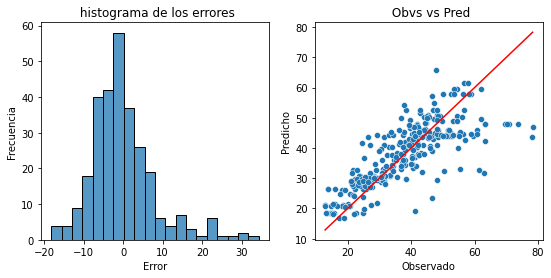

In [22]:
# entrenar el modelo con el conjunto de datos de entrenamiento completo

model_1.fit(X_train.loc[:, stg1_filter], y_train)

# cálculo de los errores de predicción del modelo de regresión lineal

y_train_pred = model_1.predict(X_train.loc[:, stg1_filter])
train_res_1 = y_train - y_train_pred

# analisis de la distribución de los errores de entrenamiento

print("Regresión Lineal")
obvs_vs_pred_plot(y_train.values,
                  model_1.predict(X_train.loc[:, stg1_filter]),
                  "")

# Análisis de los errores del modelo lineal

Una vez eliminado el efecto de la antigüedad, la cantidad de tiendas de conveniencia cercanas y la distancia a la estación MRT sobre el precio, se analiza los errores en el conjunto de datos de entrenamiento.

Como se observa en el siguiente gráfico, parece existir una dependencia entre el error del modelo lineal y la posición geográfica: en la zona sur prevalecen los errores negativos y en ciertas zonas del norte, los positivos.

Para estimar el efecto de la posición geográfica en el precio se utilizará un modelo de regresión no paramétrico, ya que nos permite capturar las relaciones no lineales entre la latitud, logitud y el precio.

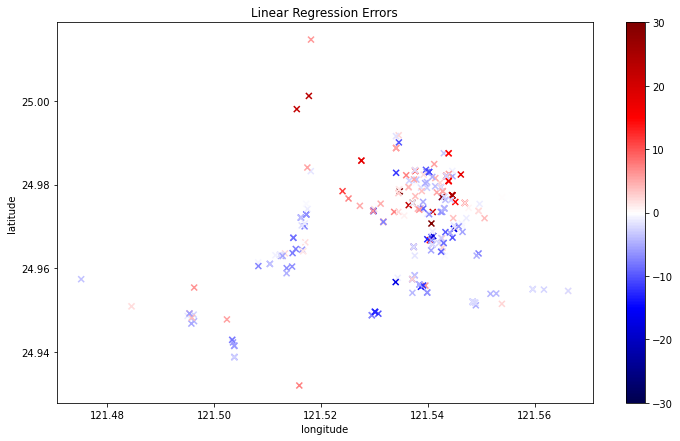

In [23]:
from matplotlib.colors import TwoSlopeNorm

fig, axis = plt.subplots(figsize=(12, 7))

axis = plt.scatter(x=X_train["longitude"], 
                   y=X_train["latitude"], 
                   c = train_res_1,
                   cmap= plt.get_cmap("seismic"),
                   marker="x",
                   norm=TwoSlopeNorm(0, vmin=-30, vmax=30)
                   )

plt.title("Linear Regression Errors")
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.colorbar();

# Estimación del efecto de la localización en el precio

En esta etapa se utilizará un modelo no paramétrico de regresión (Random Forests) para predecir los errores del modelo lineal y capturar el efecto de la posición geográfica en el precio.

En la celda "resultado 5" se muestra la estimación del error de generalización. La media es de 7.19, lo cual supone una disminición del error de 1.17. Este resultado refuerza la hipótesis de que la localidad efectivamente tiene un efecto en el precio de las casas.

Finalmente, en la celda "resultado 6", se muestra la distribución de los errores del modelo.

In [24]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

#from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
#from sklearn.svm import SVR

In [25]:
# definición del modelo

stg2_filter = ['longitude', 'latitude']

model_2 = Pipeline([
    #("PCA", PCA(n_components=2)),
    ("regressor", RandomForestRegressor(n_estimators=100, min_samples_leaf=7, random_state=0)),
])

### resultado 5

In [26]:
scoring = "neg_root_mean_squared_error"

scores = cross_val_score(model_2, X_train.loc[:, stg2_filter], 
                         train_res_1, 
                         cv=kf, # cross-validation splitter
                         scoring=scoring)

print("Estimación del error de generalización utilizando 5 fold cross-validation")
print(f"RMSE: {-scores.mean():.3f} +- {scores.std():.3f}")

Estimación del error de generalización utilizando 5 fold cross-validation
RMSE: 7.196 +- 1.263


### resultado 6

Random Forest


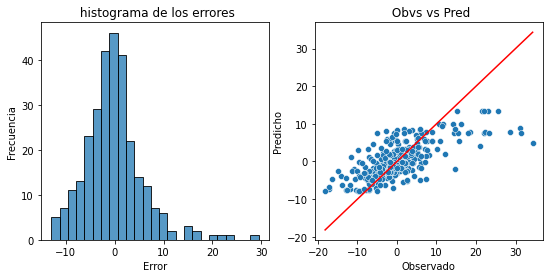

In [27]:
# entrenar el modelo con el conjunto de datos de entrenamiento completo

model_2 = clone(model_2)
model_2.fit(X_train.loc[:, stg2_filter], train_res_1);

# analisis de la distribución de los errores de entrenamiento

print("Random Forest")
obvs_vs_pred_plot(train_res_1.values,
                  model_2.predict(X_train.loc[:, stg2_filter]),
                  "")

# Comparación con un modelo no paramétrico

Adicionalmente, para evaluar el rendimiento el modelo anteriormente entrenado (reg lineal + random forest), se entrenará modelo Random Forests utilizando todas las variables de entrada.

En la celda "resultado 7", se reporta el error de generalización estimado. La media es de 6.80, el cual es ligeramente menor que el modelo anteriormente estimado (lin reg + random forest).

In [28]:
# definición del modelo

full_model = Pipeline([
    ("regressor", RandomForestRegressor(n_estimators=100, min_samples_leaf=2, random_state=0)),
])

full_filter = ['house_age', 
               'distance_to_nearest_MRT_station',
               'number_of_convenience_stores', 
               'latitude', 
               'longitude']

### resultado 7

In [29]:
# Estimación del error de generalización utilizando 5-fold cross-validation

scoring = "neg_root_mean_squared_error"

scores = cross_val_score(full_model, X_train.loc[:, full_filter], 
                         y_train, 
                         cv=kf, # cross-validation splitter
                         scoring=scoring)

print("Estimación del error de generalización utilizando 5 fold cross-validation")
print(f"RMSE: {-scores.mean():.3f} +- {scores.std():.3f}")

Estimación del error de generalización utilizando 5 fold cross-validation
RMSE: 6.809 +- 0.961


Full Random Forest


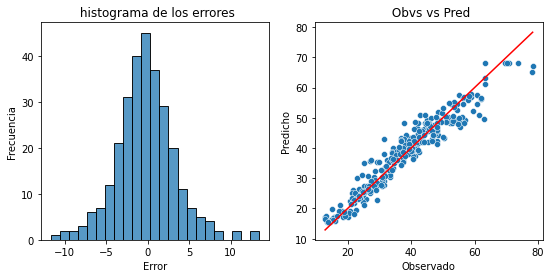

In [30]:
# entrenar el modelo con el conjunto de datos de entrenamiento completo

full_model.fit(X_train.loc[:, full_filter], y_train);

# analisis de la distribución de los errores de entrenamiento

print("Full Random Forest")
obvs_vs_pred_plot(y_train,
                 full_model.predict(X_train.loc[:, full_filter]),
                 "")

# Evaluación final de los modelos

Finalmente, se comparará sendos modelos utilizando el conjunto de datos de test. Esta es la prueba final a la que se someterán los modelos.

Errores en el conjunto de datos de test
- __Reg Lineal__: 7.418
- __Reg Lineal + Random Forest__: 6.840
- __Full Random Forest__: 6.765

Estos números indican lo siguiente:

- La reducción del error en test obtenida al añadir el modelo random forest a la regresión lineal refuerza la hipótesis de que la localidad geográfica efectivamente influencia en el precio.

- El error en test del modelo "Full Random Forest" es similar al del modelo "Reg Lineal + Random Forest". Esto valida que el modelo híbrido efectivamente ha encontrado relaciones significativas entre las variables de entrada y la de salida.

In [31]:
# función que nos permite hallar combinar las predicciones de dos modelos

def final_prediction(model_1, filter_1, model_2, filter_2, X):
    """
    Esta función nos permite combinar las predicciones de los modelos
    model_1 y model_2 en el conjunto de datos X.
    """
    y_pred = model_1.predict(X.loc[:, filter_1]) + model_2.predict(X.loc[:, filter_2]) 
    return y_pred

In [32]:
# crear las variables adicionales en el conjunto de test

X_test["log_MRT_dist"] = np.log(X_test["distance_to_nearest_MRT_station"]+1)

Modelo de regresión lineal
Test RMSE: 7.418


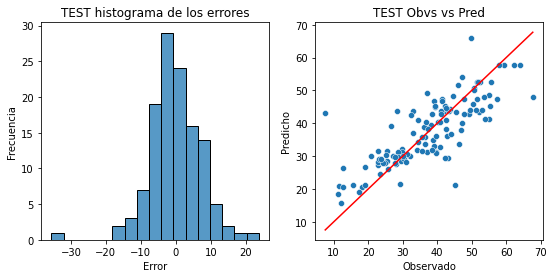

In [33]:
# evaluación en test del modelo de regresión lineal

y_pred_test_RL = model_1.predict(X_test.loc[:, stg1_filter])

print("Modelo de regresión lineal")
print(f"Test RMSE: {RMSE(y_test, y_pred_test_RL):.3f}")
obvs_vs_pred_plot(y_test, y_pred_test_RL, "TEST")

Modelo random forest + regresión lineal
Test RMSE: 6.840


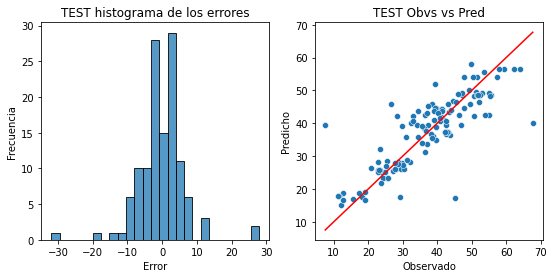

In [34]:
# evaluación  en test del modelo regresión lineal + random forest

y_pred_test = final_prediction(model_1, stg1_filter, model_2, stg2_filter, X_test)

print("Modelo random forest + regresión lineal")
print(f"Test RMSE: {RMSE(y_test, y_pred_test):.3f}")
obvs_vs_pred_plot(y_test, y_pred_test, "TEST")

Modelo full random forest
Test RMSE: 6.765


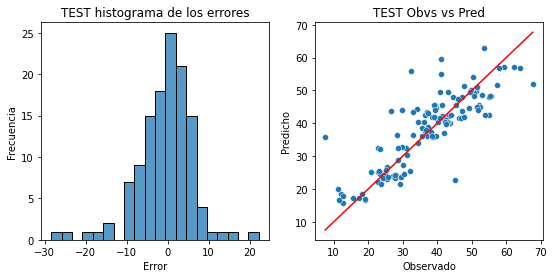

In [35]:
# evaluación  en test del modelo full random forest
y_test_pred_FRF = full_model.predict(X_test.loc[:, full_filter])

print("Modelo full random forest")
print(f"Test RMSE: {RMSE(y_test, y_test_pred_FRF):.3f}")
obvs_vs_pred_plot(y_test, y_test_pred_FRF, "TEST")

# Interpretación del modelo Lin Reg + Random Forest

En esta última estapa se interpreta los resultados obtenidos por el modelo "Reg Lineal + Random Forest"

En el siguiente gráfico se observa el efecto parcial de las variables utilizadas en la etapa de regresión lineal. Adicionalmente, se grafica los valores del conjunto de datos de test.

Se observa que la distancia a las estación MRT (en logaritmo) y la antigüedad de la propiedad tienen un efecto negativo en el precio, mientras que la cantidad de tiendas de conveniencia cercanas tiene un efecto lineal positivo.

In [36]:
def f(x, c): return model_1[0].coef_[c]*x

def gen_linspace(x): return np.linspace(x.min(), x.max(), 25)

def graficar_efecto_parcial(var_name, coef_index, axis_index, X, y, y_pred):
    # graficar la linea de regresión
    x_ = gen_linspace(X_train[var_name])
    y_ = f(x_, coef_index)
    sns.lineplot(x=x_, y=y_, ax=axis[axis_index])
    # 
    sns.scatterplot(x=X.loc[:, var_name], 
                    y=y - y_pred + f(X[var_name], coef_index),
                    ax = axis[axis_index])
    #
    axis[axis_index].set_title(f"coef reg lineal: {model_1[0].coef_[coef_index]:.3f}")
    axis[axis_index].set_ylabel(f"Efecto parcial en el precio")

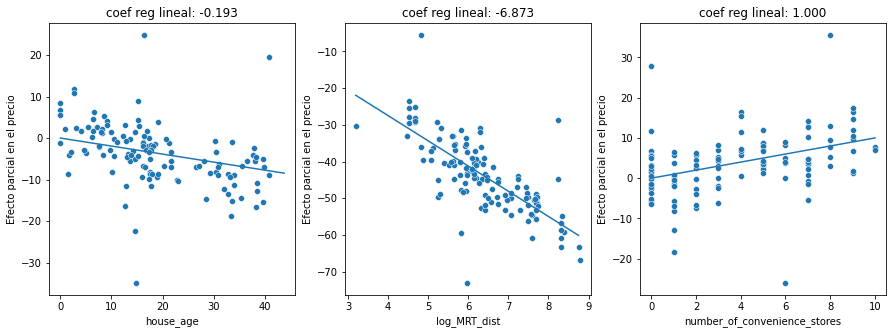

In [37]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

y_test_pred = final_prediction(model_1, stg1_filter, model_2, stg2_filter, X_test)

graficar_efecto_parcial("house_age", 0, 0, X_test, y_test, y_test_pred)
graficar_efecto_parcial("log_MRT_dist", 1, 1, X_test, y_test, y_test_pred)
graficar_efecto_parcial("number_of_convenience_stores", 2, 2, X_test, y_test, y_test_pred)

Finalmente, se analiza el efecto de la localización en el precio por unidad de área, el cual es estimado por el modelo Random Forest.

Como se observó anteriormente, las propiedades del sur tienden a sufrir una penalización negativa en el precio, mientras que en ciertas zonas del norte, obtienen bonficaciones positivas.

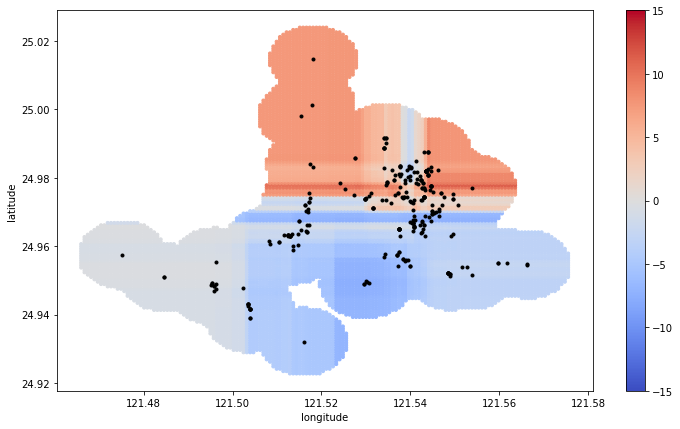

In [38]:
plot_surface(X_train.loc[:, stg2_filter].values, train_res_1, model_2, 
             N=150,
             show_train_data=True)

# Conclusiones
- Técnicas paramétricas y no paramétricas pueden ser combinadas mediante el modelamiento en etapas. En este caso, la combinación de regresión lineal con random forests permite la construcción de un modelo con un poder prredictivo similar al de técnicas no paramétricas y que, gracias a su estructura aditiva, puede ser fácilmente interpretado.